In [1]:
#CEll_1.
# -*- coding: utf-8 -*-
import os
import cv2
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix

2024-11-21 02:45:47.574678: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 02:45:47.617721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 02:45:47.618814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 02:45:48.304647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#CEll_2.
IMAGESIZE = 64  #読み込んだ画像は(IMAGESIZE,IMAGESIZE)のサイズにリサイズする

# ディレクトリ内の画像を読み込む
# inputpath: ディレクトリ文字列, imagesize: 画像サイズ, type_color: ColorかGray
def load_images(inputpath, imagesize, type_color):
    imglist = []
    filenamelist = []

    for root, dirs, files in os.walk(inputpath):
        for fn in sorted(files):
            bn, ext = os.path.splitext(fn)
            if ext not in [".bmp", ".BMP", ".jpg", ".JPG", ".jpeg", ".JPEG", ".png", ".PNG"]:
                continue

            filename = os.path.join(root, fn)
            
            if type_color == 'Color':
                # カラー画像の場合
                testimage = cv2.imread(filename, cv2.IMREAD_COLOR)
                # サイズ変更
                height, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, (imagesize, imagesize), interpolation = cv2.INTER_AREA)  #主に縮小するのでINTER_AREA使用
                testimage = np.asarray(testimage, dtype=np.float64)
                # 色チャンネル，高さ，幅に入れ替え．data_format="channels_first"を使うとき必要
                #testimage = testimage.transpose(2, 0, 1)
                # チャンネルをbgrの順からrgbの順に変更
                testimage = testimage[:,:,::-1]
            
            elif type_color == 'Gray':
                # グレースケール画像の場合
                testimage = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                # サイズ変更
                height, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, (imagesize, imagesize), interpolation = cv2.INTER_AREA)  #主に縮小するのでINTER_AREA使用
                # チャンネルの次元がないので1次元追加する
                testimage = np.asarray([testimage], dtype=np.float64)
                testimage = np.asarray(testimage, dtype=np.float64).reshape((imagesize, imagesize, 1))
                # チャンネル，高さ，幅に入れ替え．data_format="channels_first"を使うとき必要
                #testimage = testimage.transpose(2, 0, 1)

            imglist.append(testimage)
            filenamelist.append(fn)
    imgsdata = np.asarray(imglist, dtype=np.float32)

    return imgsdata, filenamelist  # 画像リストとファイル名のリストを返す


In [3]:
#CEll_3.
### データ準備 ###
print('*** Loading images ***')

# 画像読み込みとラベル値作成
# クラス0
image0, filenames_image0 = load_images('./sundatabase_negative/', IMAGESIZE, 'Color')
label0 = np.full(image0.shape[0], 0)    #画像数と同数のラベル値を含むリスト

# クラス1
image1, filenames_image1 = load_images('./sundatabase_positive/', IMAGESIZE, 'Color')
label1 = np.full(image1.shape[0], 1)    #画像数と同数のラベル値を含むリスト


# 画像，ラベル値，ファイル名それぞれ1つの配列にまとめる
image_all = np.concatenate([image0, image1], axis=0)
label_all = np.append(label0, label1)
filename_all = filenames_image0 + filenames_image1


*** Loading images ***


In [4]:
#CEll_4.
indices = np.array(range(image_all.shape[0]))
image_train, image_test, label_train, label_test, index_train, index_test = train_test_split(image_all, label_all, indices, test_size=0.2)

In [5]:
#Cell_5.
print(indices)
print(len(label_train))
print(len(label_test))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219]
176
44


In [6]:
#Cell_6.
# testデータのファイル名リスト作成
filenames_test = []
for i in range(len(index_test)):
    filenames_test.append(filename_all[index_test[i]])


# 画像の画素値を0-1に正規化
image_train /= 255.0
image_test /= 255.0

# ラベルをone hot vector形式に変換
label_train_binary = to_categorical(label_train)
label_test_binary = to_categorical(label_test)

print('Loaded images: ' + repr(image_train.shape[0]) + ' for training and ' + repr(image_test.shape[0]) + ' for testing.')


Loaded images: 176 for training and 44 for testing.


In [7]:
#Cell_7.
### 画像分類モデル定義と学習処理の実行 ###
print('*** Training ***')

# 分類モデル定義
# 基本的な分類CNN
def classification_model():
    input_img = Input(shape=(IMAGESIZE, IMAGESIZE, 3))

    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=4, strides=4)(x)

    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=4, strides=4)(x)

    x = Flatten()(x)

    x = Dense(50)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(10)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(2)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    return model


# 分類モデル定義関数を呼び出す
model = classification_model()

# モデルを表示
print(model.summary())



*** Training ***
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 64)        0         
                                            

In [8]:
#Cell_8.
# traininigの設定
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# training実行
training = model.fit(image_train, label_train_binary, epochs=3, batch_size=2, verbose=1)

Epoch 1/3
88/88 [==============================] - 1s 3ms/step - loss: 0.6908 - accuracy: 0.5398
Epoch 2/3
88/88 [==============================] - 0s 3ms/step - loss: 0.4978 - accuracy: 0.7955
Epoch 3/3
88/88 [==============================] - 0s 3ms/step - loss: 0.4770 - accuracy: 0.7898


In [9]:
#Cell_9.
### 学習済みモデルの評価 ###
print('*** Testing ***')

# testデータの分類精度を表示
scores = model.evaluate(image_test, label_test_binary, batch_size=5, verbose=0)
print("%s on test data: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#Confusion matrixを表示
results = model.predict(image_test, batch_size=5, verbose=1)
results_argmax = list(np.argmax(results, axis=-1))
cmatrix = confusion_matrix(label_test, results_argmax)
print('Confusion matrix:')
print(cmatrix)

*** Testing ***
accuracy on test data: 100.00%
9/9 [==============================] - 0s 3ms/step
Confusion matrix:
[[23  0]
 [ 0 21]]


In [10]:
#Cell_10.
# testデータの分類結果をcsvファイルに書き出し
f = open('./result.csv', 'w')
writer = csv.writer(f, lineterminator='\n')

savedata = ['filename', 'true_class', 'estimate_class', 'estimate_likelihood_max', 'estimate_likelihood_class0', 'estimate_likelihood_class1']
writer.writerow(savedata)

for i in range(len(image_test)):
    savedata = [filenames_test[i], label_test[i], np.argmax(results[i]), np.max(results[i]), results[i][0], results[i][1]]
    writer.writerow(savedata)
    
f.close()

In [11]:
#Cell_11.
target_layer = model.get_layer("conv2d_1")
intermediate_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])
label_test

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])

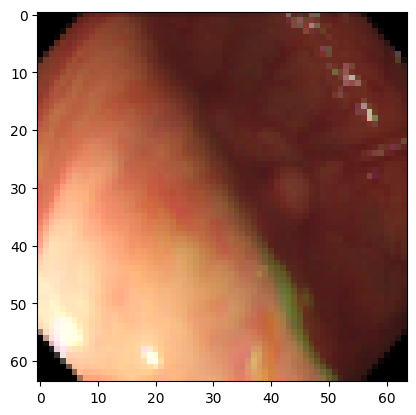

In [12]:
#Cell_12.
idx = 0 #空欄を埋めよ。
input_img = image_test[idx]
import matplotlib.pyplot as plt
plt.imshow(input_img)

In [13]:
#Cell_13.
import tensorflow as tf
import numpy as np

# Grad-CAMの計算
input_img_tensor = tf.convert_to_tensor(input_img.reshape(1, 64, 64, 3))  # NumPy配列をテンソルに変換
with tf.GradientTape() as tape:
    tape.watch(input_img_tensor)  # ここでテンソルをwatch
    conv_output, predictions = intermediate_model(input_img_tensor)
    class_idx = np.argmax(predictions[0])
    loss = predictions[:, class_idx]

In [14]:
#Cell_14.
grads = tape.gradient(loss, conv_output)[0] 
print(grads)

tf.Tensor(
[[[ 0.          0.          0.         ... -0.         -0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.00708702 ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.00607395 ...  0.          0.
    0.        ]]

 [[ 0.00954273  0.00680244  0.         ...  0.          0.
    0.00100871]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        

In [15]:
#Cell_15.
weights = np.mean(grads, axis=(0, 1))

In [16]:
#Cell_16.
cam = np.dot(conv_output[0], weights) # 線形結合(Linear combination)
cam = np.maximum(cam, 0)  # ReLU

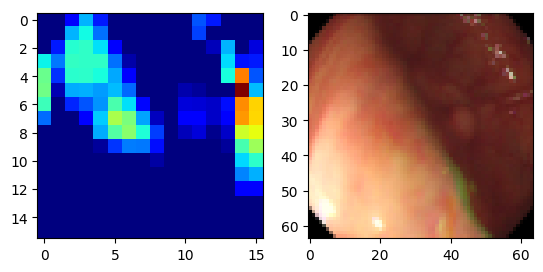

In [17]:
#Cell_17.
cam = cam / cam.max()  # 正規化

plt.subplot(121)
plt.imshow(cam, cmap="jet")

plt.subplot(122)
plt.imshow(input_img, cmap='gray')

plt.show()

In [18]:
#Cell_18.
from scipy.ndimage import zoom

# 特徴マップを64x64にアップサンプリング
zoom_factor = 64 / 16  # 64: ターゲットのサイズ, 4: 元のサイズ
cam_resized = zoom(cam, zoom_factor)


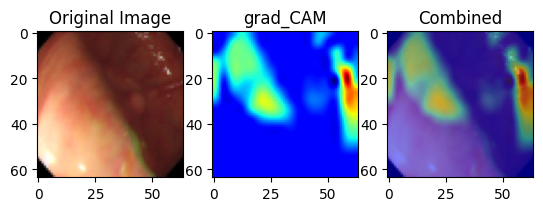

In [19]:
#Cell_19.
plt.subplot(131)
plt.title("Original Image")
plt.imshow(input_img, cmap="gray")

plt.subplot(132)
plt.title("grad_CAM")
plt.imshow(cam_resized, cmap="jet")

plt.subplot(133)
plt.title("Combined")
plt.imshow(input_img, cmap="gray")
plt.imshow(cam_resized, cmap='jet', alpha=0.5) 

plt.show()

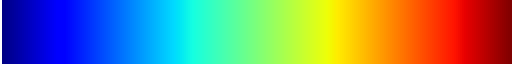

In [20]:
#Cell_20.
import matplotlib.colors as mcolors

# カラーマップ
cmap = plt.get_cmap('jet')
cmaplist = [cmap(i) for i in range(cmap.N)]
# 0の値を無色透明にする
cmaplist[0] = (1, 1, 1, 0.0)  # (R, G, B, Alpha)
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', cmaplist, cmap.N)
cmap_custom

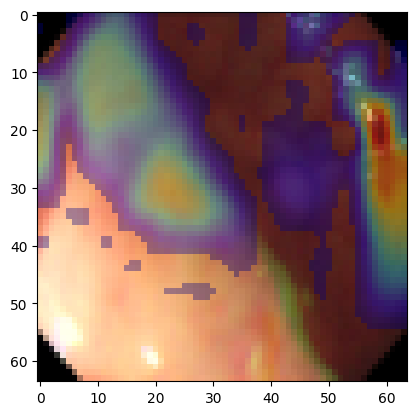

In [21]:
#Cell_21.
import matplotlib.colors as mcolors

# 元の画像
plt.imshow(input_img, cmap='gray')
# CAMを透過してオーバーレイ表示
plt.imshow(cam_resized, cmap=cmap_custom, alpha=0.35, vmin=0)

plt.show()